In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import *

In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float

epochs = 20
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [8]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [9]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [10]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [11]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = resnet18(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


In [13]:
# model.eval()
for i in model.parameters():
    pass
#     print(i.shape)
#     print((i[0].type()))
state_dict = model.state_dict()
for i in state_dict :
    print(i)
#     if 'conv1.weight' in i :
#         print(state_dict[i][0,0])

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

In [14]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [15]:
# training function
def fit(model, dataloader):
#     print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [16]:
#validation function
def validate(model, dataloader):
#     print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [17]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

  0%|          | 0/94 [00:00<?, ?it/s]

Training on 6073 examples, validating on 911 examples...


95it [00:09, 10.50it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.62it/s]

Train Loss: 0.0516, Train Acc: 30.64


15it [00:01, 12.32it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.00it/s]

Val Loss: 0.0498, Val Acc: 37.54


95it [00:09, 10.50it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.95it/s]

Train Loss: 0.0385, Train Acc: 43.60


15it [00:01, 12.29it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.04it/s]

Val Loss: 0.0416, Val Acc: 46.32


95it [00:08, 10.71it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  9.65it/s]

Train Loss: 0.0311, Train Acc: 52.46


15it [00:01, 12.21it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.92it/s]

Val Loss: 0.0325, Val Acc: 52.14


95it [00:08, 10.72it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.96it/s]

Train Loss: 0.0249, Train Acc: 61.45


15it [00:01, 12.31it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.83it/s]

Val Loss: 0.0316, Val Acc: 55.10


95it [00:08, 10.67it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.95it/s]

Train Loss: 0.0193, Train Acc: 69.50


15it [00:01, 12.39it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.91it/s]

Val Loss: 0.0273, Val Acc: 59.71


95it [00:09, 10.42it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.75it/s]

Train Loss: 0.0145, Train Acc: 77.00


15it [00:01, 12.39it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.91it/s]

Val Loss: 0.0271, Val Acc: 59.71


95it [00:09, 10.53it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.90it/s]

Train Loss: 0.0102, Train Acc: 83.45


15it [00:01, 12.49it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.02it/s]

Val Loss: 0.0231, Val Acc: 62.57


95it [00:08, 10.67it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.96it/s]

Train Loss: 0.0065, Train Acc: 89.97


15it [00:01, 12.48it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.04it/s]

Val Loss: 0.0228, Val Acc: 67.73


95it [00:08, 10.57it/s]                        
 14%|█▍        | 2/14 [00:00<00:00, 12.01it/s]

Train Loss: 0.0035, Train Acc: 95.75


15it [00:01, 12.42it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.85it/s]

Val Loss: 0.0219, Val Acc: 66.96


95it [00:08, 10.75it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.94it/s]

Train Loss: 0.0017, Train Acc: 98.47


15it [00:01, 12.46it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.17it/s]

Val Loss: 0.0211, Val Acc: 69.37


95it [00:08, 10.77it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.34it/s]

Train Loss: 0.0008, Train Acc: 99.52


15it [00:01, 12.32it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.04it/s]

Val Loss: 0.0165, Val Acc: 73.44


95it [00:08, 10.74it/s]                        
 14%|█▍        | 2/14 [00:00<00:00, 12.20it/s]

Train Loss: 0.0002, Train Acc: 99.97


15it [00:01, 12.39it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.00it/s]

Val Loss: 0.0144, Val Acc: 77.28


95it [00:09, 10.49it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.79it/s]

Train Loss: 0.0001, Train Acc: 99.97


15it [00:01, 12.37it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.87it/s]

Val Loss: 0.0148, Val Acc: 77.06


95it [00:09, 10.56it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 10.93it/s]

Train Loss: 0.0001, Train Acc: 99.97


15it [00:01, 12.17it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.31it/s]

Val Loss: 0.0142, Val Acc: 76.84


95it [00:08, 10.72it/s]                        
 14%|█▍        | 2/14 [00:00<00:00, 12.03it/s]

Train Loss: 0.0001, Train Acc: 99.98


15it [00:01, 12.41it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.00it/s]

Val Loss: 0.0145, Val Acc: 76.84


95it [00:09, 10.49it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.86it/s]

Train Loss: 0.0001, Train Acc: 99.97


15it [00:01, 12.32it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.02it/s]

Val Loss: 0.0146, Val Acc: 77.06


95it [00:08, 10.73it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.90it/s]

Train Loss: 0.0000, Train Acc: 99.98


15it [00:01, 12.38it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.83it/s]

Val Loss: 0.0146, Val Acc: 76.95


95it [00:08, 10.60it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  9.79it/s]

Train Loss: 0.0000, Train Acc: 99.97


15it [00:01, 12.17it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.94it/s]

Val Loss: 0.0146, Val Acc: 77.50


95it [00:09, 10.42it/s]                        
 14%|█▍        | 2/14 [00:00<00:00, 12.04it/s]

Train Loss: 0.0000, Train Acc: 99.98


15it [00:01, 12.37it/s]                        
  1%|          | 1/94 [00:00<00:09,  9.98it/s]

Val Loss: 0.0144, Val Acc: 77.17


95it [00:09, 10.55it/s]                        
 14%|█▍        | 2/14 [00:00<00:00, 12.02it/s]

Train Loss: 0.0000, Train Acc: 99.98


15it [00:01, 12.17it/s]                        


Val Loss: 0.0148, Val Acc: 76.62
3.392250831921895 minutes


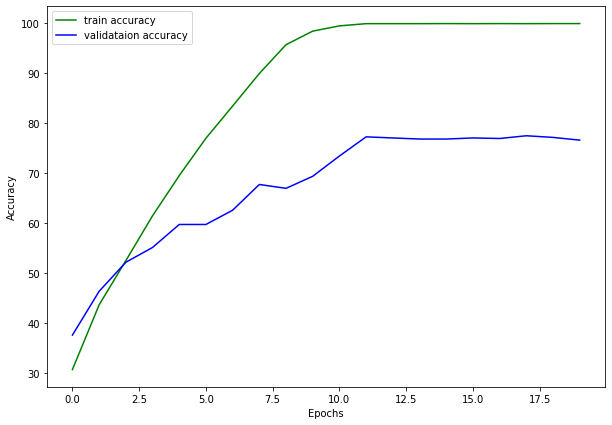

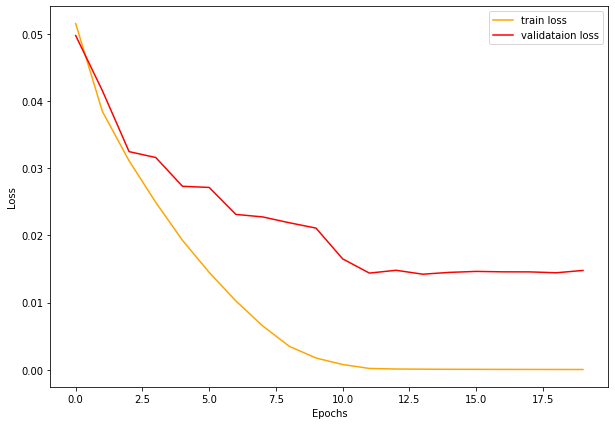

In [18]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')
torch.save(model.state_dict(), f"../trained_models/resnet18_epochs{epochs}.pth")
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/plots/accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/plots/loss.png')

In [19]:
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of the network on test images: 79.268 %
train.py finished running


In [20]:
state_dict = model.state_dict()
for i in state_dict :
#     print(i)
    if 'conv1.weight' in i :
        print(state_dict[i][0,0])

tensor([[ 1.2151e-02, -4.3730e-02, -4.4589e-03,  3.2283e-02, -2.3829e-02,
          4.9712e-03,  1.6414e-02],
        [ 7.1402e-03, -1.1347e-02,  2.4368e-02,  1.1709e-02,  1.8572e-02,
          5.3141e-02,  4.7464e-03],
        [ 2.5817e-02, -2.6498e-02,  4.2402e-02,  1.4934e-03,  1.6022e-02,
          1.8994e-02,  2.3671e-02],
        [ 1.8277e-02,  5.1896e-03, -4.6462e-04,  4.8585e-03, -1.8545e-02,
         -1.7063e-02,  4.7748e-02],
        [ 6.1327e-03,  5.5156e-02,  1.8681e-03,  8.5536e-02, -3.1761e-02,
         -2.1909e-02,  1.7629e-02],
        [ 2.7962e-02, -3.5830e-02,  9.5219e-05, -2.7670e-02,  2.3262e-02,
         -7.8361e-03, -1.3810e-02],
        [-1.2328e-02, -6.2282e-03,  2.8915e-03, -2.3502e-03,  6.1818e-03,
         -2.8441e-02, -3.5945e-02]], device='cuda:0')
tensor([[-0.0939, -0.0929, -0.0524],
        [ 0.0829,  0.0058, -0.0397],
        [-0.0117,  0.0017, -0.0192]], device='cuda:0')
tensor([[-0.0330,  0.0681,  0.1042],
        [ 0.1396,  0.0206, -0.0077],
        [